# Simple zonal statistics example

In [1]:
import geopandas

In [2]:
import rasterio

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from rasterio.plot import show
from rasterio.mask import mask
from rasterstats import zonal_stats
import plotly.express as px
import json

In [6]:
counties = geopandas.read_file('../data/USA/gadm41_USA_2.shp')

<Axes: >

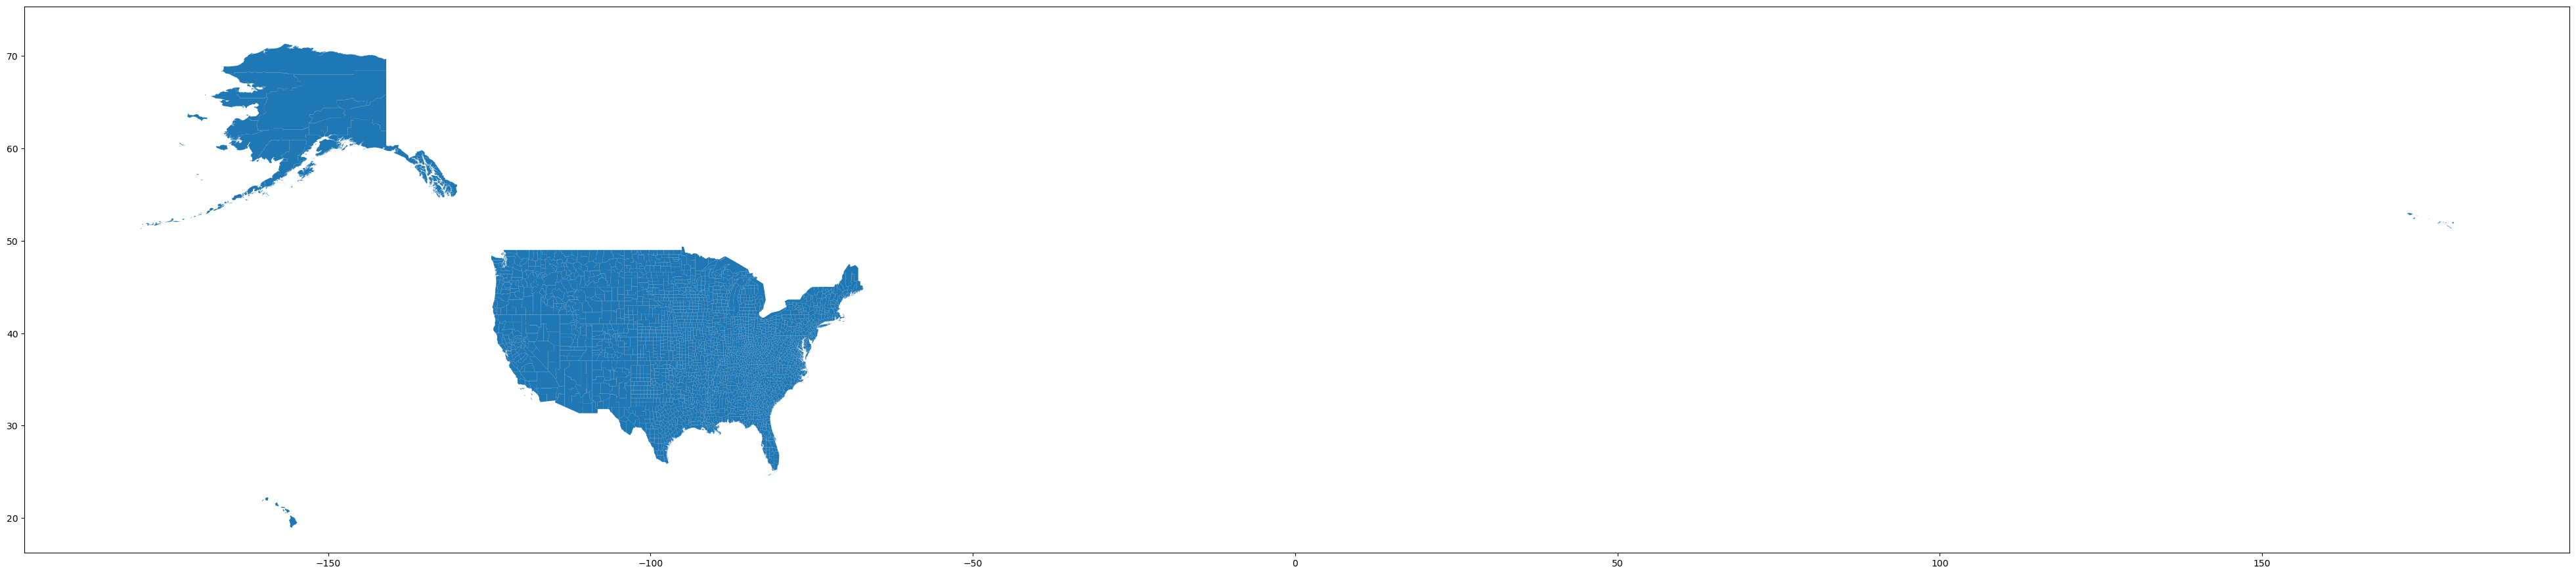

In [7]:
counties.plot(figsize=(50, 50))

In [8]:
counties.head()

GID_2 GID_0        COUNTRY    GID_1   NAME_1 NL_NAME_1   NAME_2  \
0  USA.1.1_1   USA  United States  USA.1_1  Alabama        NA  Autauga   
1  USA.1.2_1   USA  United States  USA.1_1  Alabama        NA  Baldwin   
2  USA.1.3_1   USA  United States  USA.1_1  Alabama        NA  Barbour   
3  USA.1.4_1   USA  United States  USA.1_1  Alabama        NA     Bibb   
4  USA.1.5_1   USA  United States  USA.1_1  Alabama        NA   Blount   

  VARNAME_2 NL_NAME_2  TYPE_2 ENGTYPE_2 CC_2    HASC_2  \
0        NA        NA  County    County   NA  US.AL.AU   
1        NA        NA  County    County   NA  US.AL.BD   
2        NA        NA  County    County   NA  US.AL.BR   
3        NA        NA  County    County   NA  US.AL.BI   
4        NA        NA  County    County   NA  US.AL.BU   

                                            geometry  
0  POLYGON ((-86.91668 32.66431, -86.82678 32.660...  
1  MULTIPOLYGON (((-87.74416 30.29445, -87.74389 ...  
2  POLYGON ((-85.41607 31.61962, -85.49133 31.620...  
3  POLYGON ((-87.42078 32.87446, -87.42028 32.971...  
4  POLYGON ((-86.96287 33.85858, -86.96512 33.863...

getting rid of Alaska and Hawaii for this example

In [9]:
counties = (counties[(counties.NAME_1 != 'Alaska') & 
                     (counties.NAME_1 != 'Hawaii')][
            ['NAME_1', 'NAME_2', 'geometry']]
            .reset_index(drop=True))

<Axes: >

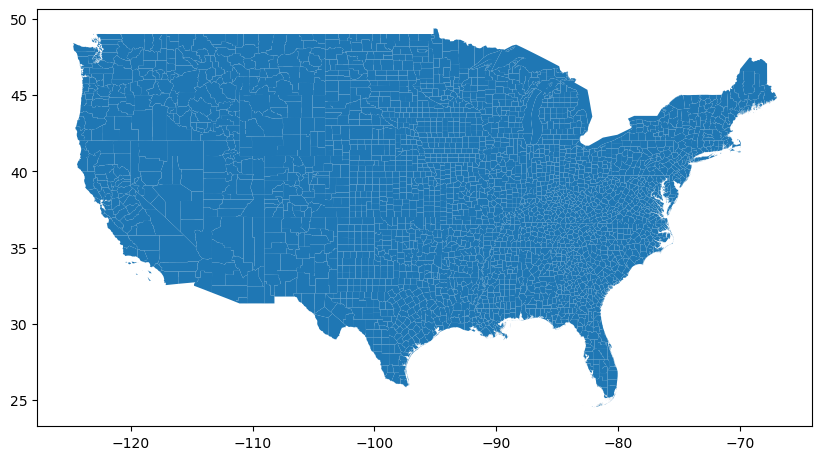

In [10]:
counties.plot(figsize=(10, 6))

In [11]:
suit = rasterio.open('../data/suit/suit/hadr.adf')

<Axes: >

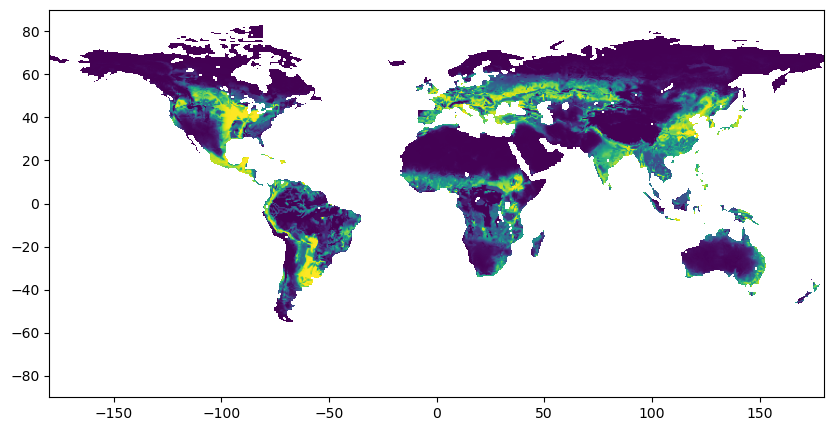

In [12]:
f, ax = plt.subplots(figsize=(10, 6))
show(suit, ax=ax)

Let's have a look at the raster metadata

In [13]:
suit.profile

{'driver': 'AIG', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 720, 'height': 360, 'count': 1, 'crs': None, 'transform': Affine(0.5, 0.0, -180.0,
       0.0, -0.5, 90.0), 'blockysize': 4, 'tiled': False}

In [14]:
suit.crs

this dataset doesnt have a projection. Let's fix that

In [15]:
crs_wgs84 = "EPSG:4326" # defining WGS84 CRS
profile=suit.profile #get profile of original raster

In [16]:
profile.update(driver='GTiff', crs=crs_wgs84) #update profile with CRS and GEOTiff 

In [17]:
suit_arr=suit.read() #read the original raster as an array

In [19]:
output_raster = '../data/agrisuit.tif'

In [20]:
with rasterio.open(output_raster, 'w', **profile) as dst:
    dst.write(suit_arr) #write the array to tiff, using updated profile

In [16]:
# infile = './data/suit/suit/hadr.adf'
# input_raster = gdal.Open(infile)
# output_raster = './data/agrisuit.tif'
# warp = gdal.Warp(output_raster,input_raster,dstSRS='EPSG:4326')
# warp = None # Closes the files

In [21]:
suit = rasterio.open('../data/agrisuit.tif')

<Axes: >

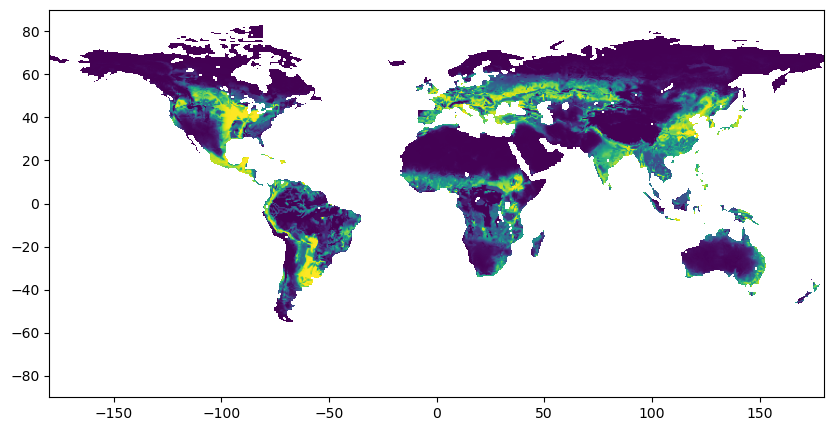

In [22]:
f, ax = plt.subplots(figsize=(10, 6))
show(suit, ax=ax)

In [23]:
suit.crs

CRS.from_epsg(4326)

getting the array and the transform

In [24]:
array = suit.read(1)
affine = suit.transform

Missing values are very large and negative for this raster -> need to fix

In [25]:
array[array < 0] = np.nan

Let's see the distribution of agricultural suitability globally

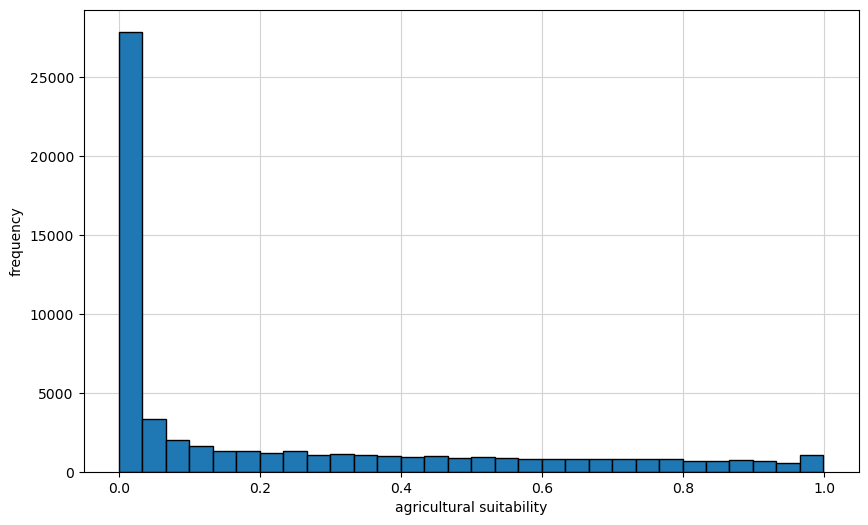

In [26]:
f, ax = plt.subplots(1,1, figsize=(10, 6))
ax.hist(array[array != np.nan].reshape(-1,1), bins=30, edgecolor='k')
ax.set_xlabel('agricultural suitability')
ax.set_ylabel('frequency')
ax.grid(color='lightgray')
ax.set_axisbelow(True)
plt.show()

Let's crop the raster to the continental US

In [27]:
suit_us_array, suit_us_transform = mask(suit, shapes=counties.geometry, crop=True, nodata=np.nan)

<Axes: >

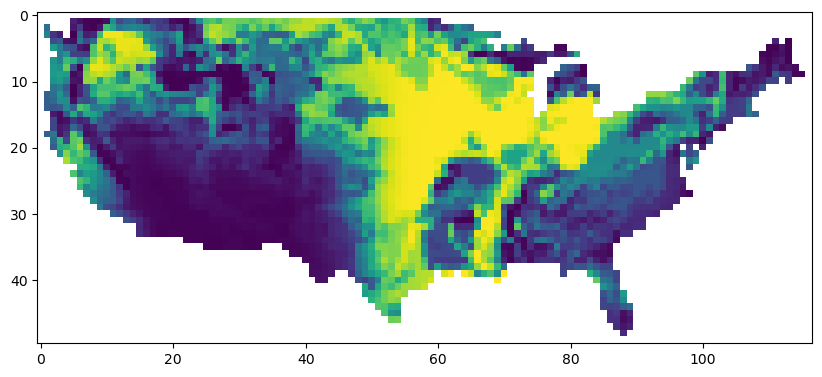

In [28]:
f, ax = plt.subplots(figsize=(10, 6))
show(suit_us_array, ax=ax)

In [30]:
suit_us_array[0]

array([[  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [  nan, 0.366,   nan, ...,   nan,   nan,   nan],
       ...,
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan]], dtype=float32)

let's see the distribution again

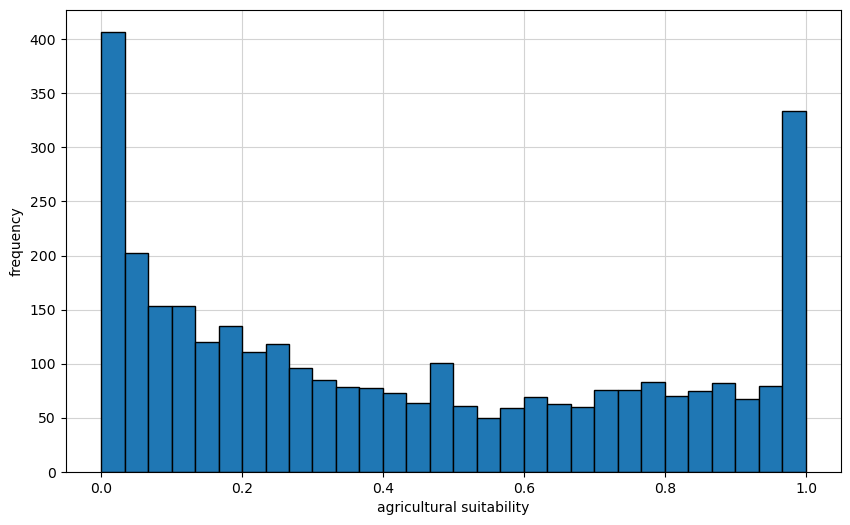

In [31]:
f, ax = plt.subplots(1,1, figsize=(10, 6))
ax.hist(suit_us_array[suit_us_array != np.nan].reshape(-1,1), bins=30, edgecolor='k')
ax.set_xlabel('agricultural suitability')
ax.set_ylabel('frequency')
ax.grid(color='lightgray')
ax.set_axisbelow(True)
plt.show()

In [32]:
zs1 = zonal_stats(counties, suit_us_array[0], affine=suit_us_transform, stats=['mean'], nodata=np.nan)    
zs2 = zonal_stats(counties, suit_us_array[0], affine=suit_us_transform, stats=['mean'], nodata=np.nan, all_touched=True)    
counties['mean_suit1'] = [x['mean'] for x in zs1]
counties['mean_suit2'] = [x['mean'] for x in zs2]

In [33]:
counties

NAME_1      NAME_2                                           geometry  \
0     Alabama     Autauga  POLYGON ((-86.91668 32.66431, -86.82678 32.660...   
1     Alabama     Baldwin  MULTIPOLYGON (((-87.74416 30.29445, -87.74389 ...   
2     Alabama     Barbour  POLYGON ((-85.41607 31.61962, -85.49133 31.620...   
3     Alabama        Bibb  POLYGON ((-87.42078 32.87446, -87.42028 32.971...   
4     Alabama      Blount  POLYGON ((-86.96287 33.85858, -86.96512 33.863...   
...       ...         ...                                                ...   
3112  Wyoming  Sweetwater  POLYGON ((-107.91540 41.00295, -107.96598 41.0...   
3113  Wyoming       Teton  POLYGON ((-111.04362 43.31358, -111.04391 43.4...   
3114  Wyoming       Uinta  POLYGON ((-111.04584 41.25143, -111.04594 41.3...   
3115  Wyoming    Washakie  POLYGON ((-108.55055 44.16851, -107.14581 44.1...   
3116  Wyoming      Weston  POLYGON ((-104.05484 43.85300, -104.05483 43.8...   

      mean_suit1  mean_suit2  
0            NaN    0.270750  
1       0.043000    0.093000  
2       0.178000    0.260750  
3            NaN    0.240750  
4            NaN    0.140250  
...          ...         ...  
3112    0.169071    0.162250  
3113    0.007200    0.063167  
3114    0.162500    0.181222  
3115    0.327500    0.312222  
3116    0.382000    0.328000  

[3117 rows x 5 columns]

<Axes: >

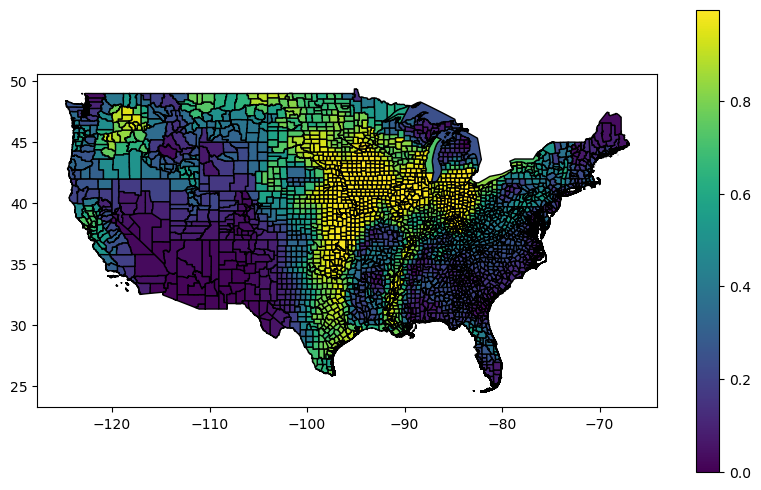

In [34]:
counties.plot(column='mean_suit2', cmap='viridis', edgecolor='k', legend=True, figsize=(10, 6))

## Optional: Using `plotly` to make interactive plots 

### Plotting the suitability array

In [30]:
fig = px.imshow(suit_us_array[0], color_continuous_scale='viridis')
fig.show()

### An interactive choropleth map

Since this can be somewhat heavy, we restrict ourselves to one state

In [35]:
tx_gdf = counties[counties.NAME_1 == 'Texas'].reset_index(drop=True)
tx_gdf

NAME_1    NAME_2                                           geometry  \
0    Texas  Anderson  POLYGON ((-96.05239 32.00476, -95.42650 32.084...   
1    Texas   Andrews  POLYGON ((-103.06408 32.08562, -103.06365 32.5...   
2    Texas  Angelina  POLYGON ((-95.00657 31.42962, -94.86890 31.525...   
3    Texas   Aransas  MULTIPOLYGON (((-97.13218 27.89810, -97.13251 ...   
4    Texas    Archer  POLYGON ((-98.95415 33.39616, -98.95327 33.833...   
..     ...       ...                                                ...   
249  Texas      Wood  POLYGON ((-95.15153 33.01230, -95.15260 32.905...   
250  Texas    Yoakum  POLYGON ((-103.06322 32.95893, -103.06317 33.0...   
251  Texas     Young  POLYGON ((-98.95415 33.39616, -98.42251 33.394...   
252  Texas    Zapata  POLYGON ((-99.44660 27.07142, -99.44653 27.071...   
253  Texas    Zavala  POLYGON ((-99.40089 28.64172, -100.11182 28.63...   

     mean_suit1  mean_suit2  
0         0.512    0.507833  
1         0.108    0.099667  
2         0.230    0.214500  
3           NaN    0.841000  
4         0.880    0.835250  
..          ...         ...  
249       0.229    0.425667  
250       0.113    0.081000  
251       0.717    0.749750  
252       0.732    0.723000  
253       0.273    0.395500  

[254 rows x 5 columns]

In [36]:
tx_gdf.to_file('../data/texas_agsuit.json', driver = 'GeoJSON')
with open('../data/texas_agsuit.json') as f:
    tx_gjson = json.load(f)    

We save it as a shapefile since we will need this in lecture 4!

In [37]:
tx_gdf.to_file('../data/texas_agsuit.shp', driver='ESRI Shapefile')

In [38]:
tx_gjson['features'][0].keys()

dict_keys(['type', 'properties', 'geometry'])

In [39]:
tx_gjson['features'][0]['properties']

{'NAME_1': 'Texas',
 'NAME_2': 'Anderson',
 'mean_suit1': 0.5120000243186951,
 'mean_suit2': 0.5078333616256714}

In [ ]:
f = px.choropleth(data_frame=tx_gdf,
                  geojson=tx_gjson,
                  color="mean_suit2",
                  locations="NAME_2",
                  featureidkey="properties.NAME_2",
                  color_continuous_scale="Viridis",
                  center={'lat': 31.75, 'lon': -99})
f.update_geos(visible=False,
              fitbounds="locations")
f.update_layout(height=300, margin={"r":0,"t":0,"l":0,"b":0})
f.show()